In [1]:
# %% imports
# libraries
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

# local imports
import MNIST_dataloader
import autoencoder_template
from main_template import test_model, load_model

# %% set torches random seed
torch.random.manual_seed(0)

# %% preperations
# define parameters
data_loc = '5LSL0-Datasets' #change the data location to something that works for you
batch_size = 64
learning_rate = 1e-3

# get dataloader
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)

# create the autoencoder
model = autoencoder_template.AE()
# create the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
criterion = nn.MSELoss()

def eval(model, dataloader):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
            # fill in how to train your network using only the clean images
            if torch.cuda.is_available():
                device = torch.device('cuda:0')
                x_clean, x_noisy, label = [x.cuda() for x in [x_clean, x_noisy, label]]
                model.to(device)
            latent, score = model(x_clean)
            loss = criterion(score,x_clean)
            loss_test += loss.item()

    return loss_test / len(dataloader)

# %% training loop
# go over all epochs
def train(model,optimizer,criterion,epochs,file_name):
    model.train()
    loss_train = 0.0
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        # go over all minibatches
        for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
            # fill in how to train your network using only the clean images
            if torch.cuda.is_available():
                device = torch.device('cuda:0')
                x_clean, x_noisy, label = [x.cuda() for x in [x_clean, x_noisy, label]]
                model.to(device)
            latent, score = model(x_clean)
            loss = criterion(score,x_clean)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        train_loss.append(loss_train/len(train_loader))
        test_loss.append(eval(model,test_loader))
        loss_train = 0.0

    torch.save(model, file_name + str(epochs) + '.pth')

    return model, latent, score, train_loss, test_loss

#%%
# move back to cpu    
# get some examples
def image_plot(model):
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    latent, score= model(x_clean_example.cuda())
    latent = latent.data.cpu().numpy()
    score = score.data.cpu().numpy()
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(3,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3,10,i+11)
        plt.imshow(latent[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3,10,i+21)
        plt.imshow(score[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    #plt.savefig("Fig/Exercise_1_image.png",dpi=300,bbox_inches='tight')
    plt.show()  

#%%
def loss_plot(train_loss, val_loss):
    plt.figure(figsize=(12,6))
    plt.plot(train_loss,label = "Train loss")
    plt.plot(val_loss, label = "Validation loss")
    plt.title('Train and Validation Losses')
    plt.xlabel('Epoch[n]')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig("Fig/Exercise_1_loss.png",dpi=300,bbox_inches='tight')

def load_model(filename):
    """ Load the trained model.
    Args:
        model (Model class): Untrained model to load.
        filename (str): Name of the file to load the model from.
    Returns:
        Model: Model with parameters loaded from file.
    """
    model = torch.load(filename)
    return model


In [17]:
model, latent, score, train_loss, test_loss = train(model, optimizer, criterion, 20, 'AE_')

100%|██████████| 157/157 [00:01<00:00, 103.88it/s]


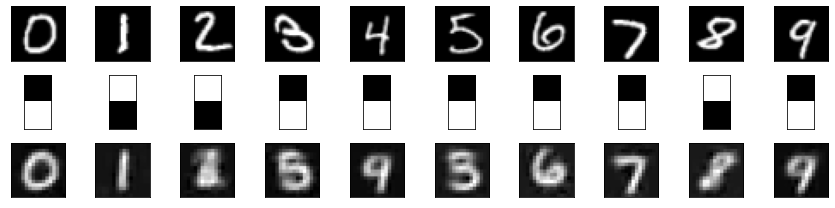

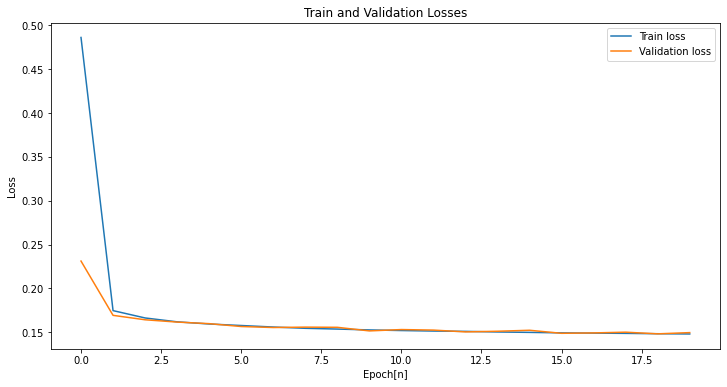

In [18]:
image_plot(model)
loss_plot(train_loss, test_loss)

In [19]:
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

In [20]:
def dataloader_type_change(model,dataloader):
    x_clean, x_noisy, labels = test_model(model,dataloader)
    x_clean = torch.cat(x_clean, dim = 0)
    x_noisy= torch.cat(x_noisy, dim = 0)
    labels = torch.cat(labels, dim = 0)
    return x_clean, x_noisy, labels

def get_latent(x_clean, labels, model):
    latent, score = model(x_clean)
    latent = latent.data.cpu().numpy()
    labels = torch.Tensor.numpy(labels)
    return latent, labels

def scatter_plot(latent,label):
    fig,ax = plt.subplots(figsize=(16,9))
    scatter = ax.scatter(latent[:,0,0,0],latent[:,0,1,0],c=label)
    legend = ax.legend(*scatter.legend_elements(),loc='upper right',title='digits')
    ax.add_artist(legend)
    plt.title('latent scatter')
    plt.show()

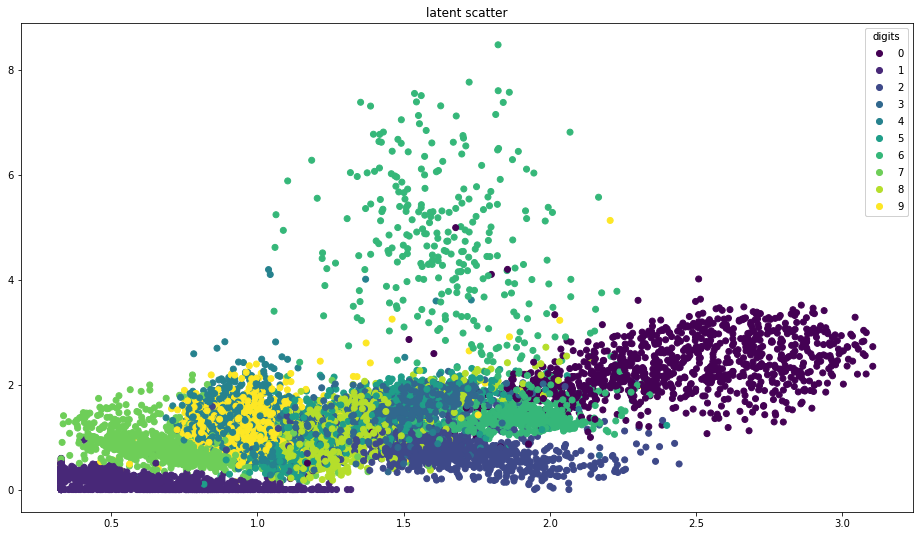

In [21]:
# model = load_model('AE_20.pth')
latent_test, labels_test = get_latent(x_clean_test.cuda(),labels_test,model)
scatter_plot(latent_test,labels_test)

In [29]:
def eval4(model, dataloader):
    model.eval()
    loss_test = 0
    with torch.no_grad():
        for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
            # fill in how to train your network using only the clean images
            if torch.cuda.is_available():
                device = torch.device('cuda:0')
                x_clean, x_noisy, label = [x.cuda() for x in [x_clean, x_noisy, label]]
                model.to(device)
            pred = model(x_clean)
            loss = criterion(pred,label)
            loss_test += loss.item()

    return loss_test / len(dataloader)

def train4(model,optimizer,criterion,epochs,file_name):
    model.train()
    loss_train = 0.0
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        # go over all minibatches
        for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
            # fill in how to train your network using only the clean images
            if torch.cuda.is_available():
                device = torch.device('cuda:0')
                x_clean, x_noisy, label = [x.cuda() for x in [x_clean, x_noisy, label]]
                model.to(device)
            pred = model(x_clean)
            loss = criterion(pred,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        train_loss.append(loss_train/len(train_loader))
        test_loss.append(eval4(model,test_loader))
        loss_train = 0.0

    torch.save(model, file_name + str(epochs) + '.pth')

    return model, train_loss, test_loss

def loss_plot4(train_loss, test_loss):
    plt.figure(figsize=(12,6))
    plt.plot(train_loss, label = "Train loss")
    plt.plot(test_loss, label = "Test loss")
    plt.title('Train and Test Losses')
    plt.xlabel('Epoch[n]')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("Fig/Exercise_4_loss.png",dpi=300,bbox_inches='tight')

In [31]:
model  = autoencoder_template.Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
model, train_loss, test_loss = train4(model, optimizer, criterion, 100, 'Classifier_')

100%|██████████| 157/157 [00:00<00:00, 273.06it/s]


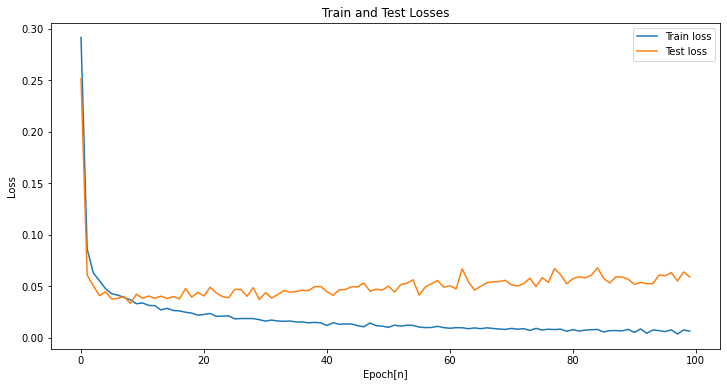

In [32]:
loss_plot4(train_loss, test_loss)

In [33]:
x_grid = np.linspace(0.1,3,15)
y_grid = np.linspace(0.1,6,15)[::-1] # from top to buttom

In [44]:
x_sample, y_sample = np.meshgrid(x_grid,y_grid)
latent_sample = np.stack((x_sample.flatten(),y_sample.flatten()),axis=1)

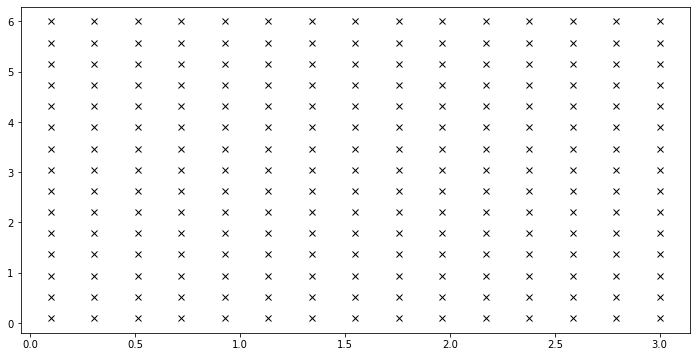

In [59]:
plt.figure(figsize=(12,6))
plt.plot(latent_sample[:, 0], latent_sample[:, 1], marker='x', color='k', linestyle='none')
plt.show()

In [82]:
latent_sample_tensor = torch.from_numpy(latent_sample).float().unsqueeze(1).unsqueeze(3).cuda()


In [90]:
model = load_model('AE_40.pth')
model.eval()
decoder = model.decoder(latent_sample_tensor)
decoder_grid = decoder.data.cpu().numpy()

In [114]:
def mnistgrid_plot(images, x_idx, y_idx):
    # plot the images in a grid
    plt.figure(figsize=(12, 12))
    for j in range(y_idx):
        for i in range(x_idx):
            img_idx = i + j * x_idx + 1
            plt.subplot(x_idx, y_idx, img_idx)
            plt.imshow(images[img_idx-1, 0, :, :], cmap='gray')
            plt.xticks([])
            plt.yticks([])

    plt.tight_layout()
    plt.savefig("Fig/Exercise_5_image.png", dpi=300, bbox_inches='tight')
    plt.show()

def denoise_plot(model):
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)

    latent, output = model(x_clean_example.cuda())
    output = output.data.cpu().numpy()

    plt.figure(figsize=(36,9))
    for i in range(10):        
        plt.subplot(4,10,i+1)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(4,10,i+11)
        plt.imshow(output[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(4,10,i+21)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.savefig("Fig/Exercise_8_image.png", dpi=300, bbox_inches='tight')
    plt.show()
    

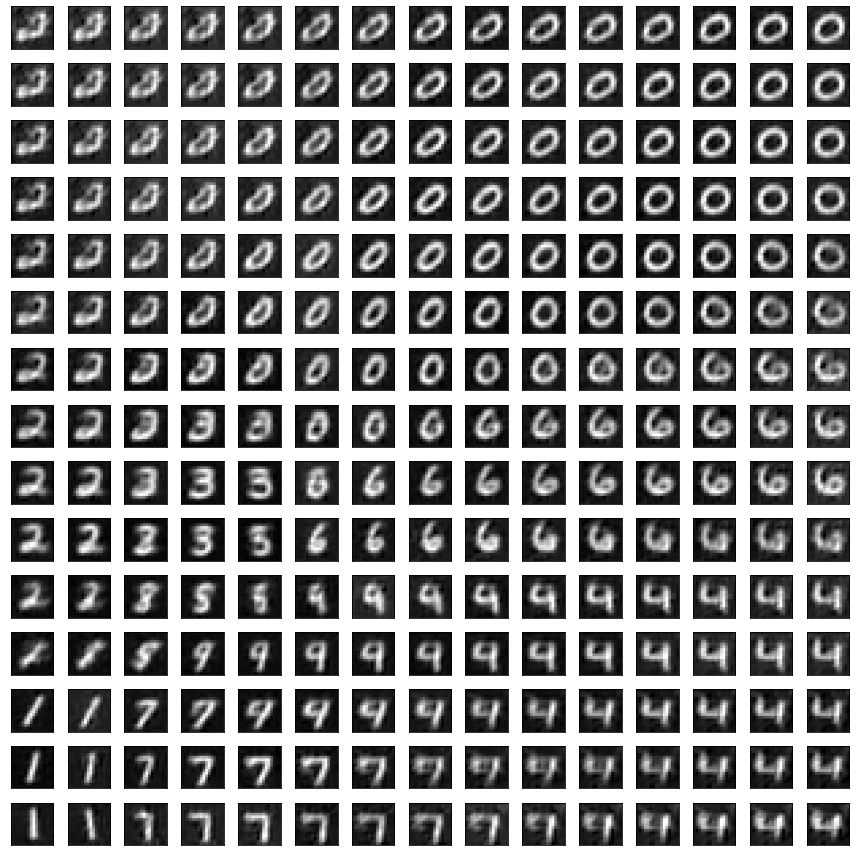

In [100]:
mnistgrid_plot(decoder_grid, 15, 15)

In [115]:
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

latent, output = model(x_clean_example.cuda())
output = output.data.cpu().numpy()

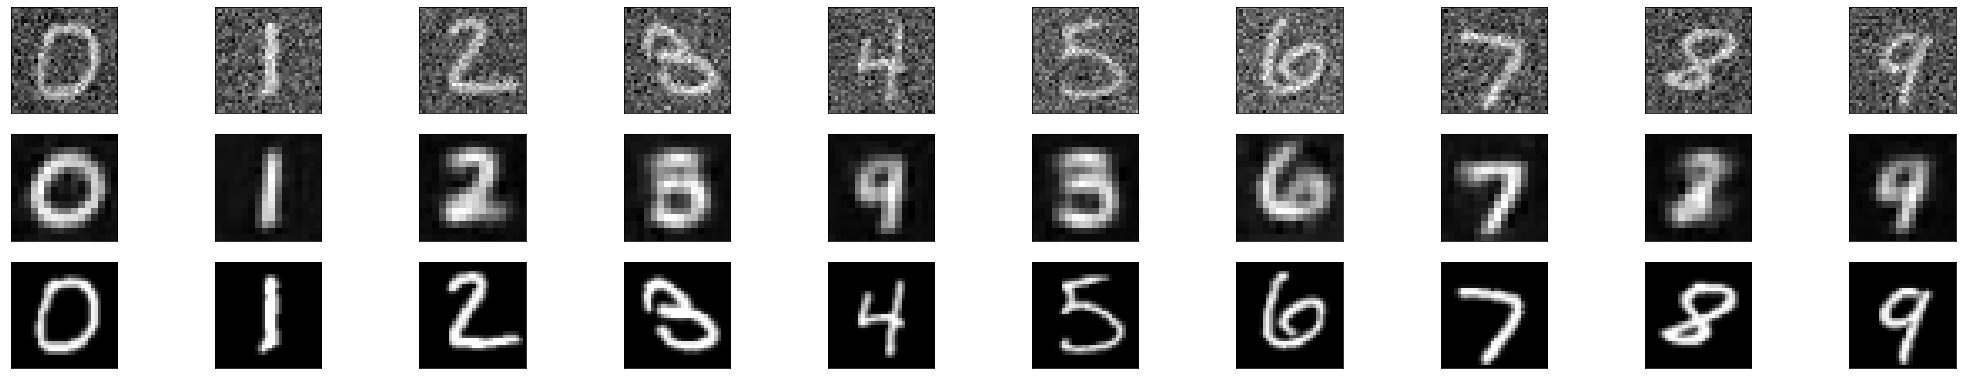

In [116]:
denoise_plot(x_noisy_example,output,x_clean_example)

In [2]:
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

In [3]:
model = load_model('Classifier_100.pth')
latent = model(x_clean_test[0:2000,:,:,:].cuda())
latent_sample = model(x_clean_train[0:10000,:,:,:].cuda())

In [4]:
latent_sample = torch.squeeze(latent_sample)
latent = torch.squeeze(latent)

In [5]:
latent_sample, latent = latent_sample.data.cpu().numpy(), latent.data.cpu().numpy()
labels_sample, labels = labels_train[0:10000], labels_test[0:2000]
print(latent_sample.shape)
print(latent.shape)

(10000, 10)
(2000, 10)


In [6]:
import pandas as pd
import seaborn as sn
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, output_labels, save_path=None):
    """
    Plot confusion matrix. See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    Args:
        true_labels: Groud truth labels
        output_labels: Model output labels
        title: title of the plot
        cmap: color map
    """
    digits = np.linspace(0, 9, 10, dtype=np.int8)

    # calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, output_labels, normalize='true')

    # get percentages of each class
    class_percentages = np.diagonal(conf_matrix)
    print("Class percentages: ", class_percentages)

    # plot confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in digits],
                        columns = [i for i in digits])
    fig, ax = plt.subplots(figsize=(12, 7))
    heatmap = sn.heatmap(df_cm, annot=True)
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 16)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 16)

    # axis titles
    heatmap.set_ylabel('True label', fontsize = 18)
    heatmap.set_xlabel('Predicted label', fontsize = 18)
    # plt.savefig(f'{save_path}', dpi=300, bbox_inches='tight')

In [7]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=1).fit(latent_sample)
distances, train_latent_indices = nbrs.kneighbors(latent)


In [8]:
train_labels_neighbours = labels_sample[train_latent_indices]

In [9]:
correct_predictions = np.equal(train_labels_neighbours, labels)

Class percentages:  [0.99428571 1.         0.96803653 0.99516908 0.97695853 0.96089385
 0.97191011 0.97560976 0.97395833 0.96907216]


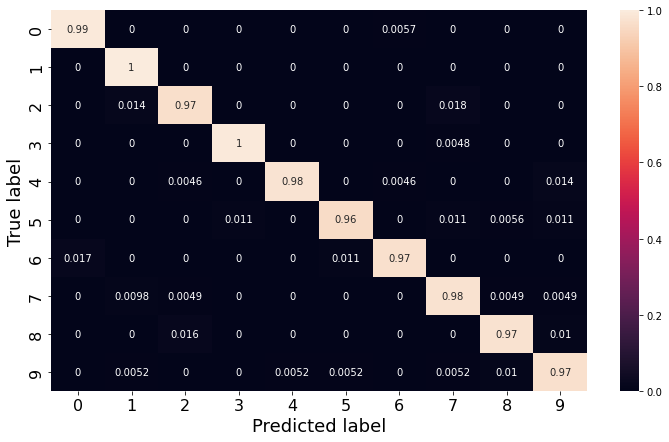

In [10]:
plot_confusion_matrix(labels, train_labels_neighbours)